In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesGeometric.nc')

# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, 3) # 3 means open boundary in both dimensions
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [3]:
# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e13)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [4]:
mie_mono_tables = OrderedDict()
for wavelength in sensors.get_unique_solvers():
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
size_distribution_function = at3d.size_distribution.gamma
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')
optical_properties = optical_properties.drop_vars('reff')

# optical_properties_swir = solvers[2.13].medium['cloud'].copy(deep=True)
# optical_properties_swir = optical_properties_swir.drop_vars('extinction')
# optical_properties_swir = optical_properties_swir.drop_vars('reff')

In [5]:
# We are using the ground_truth rte_grid.
dataset = rte_grid.copy(deep=True)
#dataset['density'] = solvers[.66].medium['cloud'].density
#dataset = dataset.reset_coords(['veff'], drop=True)
dataset["veff"] = solvers[.66].medium['cloud'].veff
dataset = dataset.reset_coords(['reff'], drop=True)
print(dataset)
micro_grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, dataset#optical_properties
    #reff = (np.zeros(rte_grid.grid.shape)+ 0.0, np.zeros(rte_grid.grid.shape) + 30)
)
grid_to_optical_properties = at3d.medium.GridToOpticalProperties(
    rte_grid,'cloud2', 0.66,optical_properties
)

<xarray.Dataset>
Dimensions:  (x: 32, y: 37, z: 27)
Coordinates:
  * x        (x) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.54 0.56 0.58 0.6 0.62
  * y        (y) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.64 0.66 0.68 0.7 0.72
  * z        (z) float64 0.0 0.44 0.48 0.52 0.56 0.6 ... 1.28 1.32 1.36 1.4 1.44
Data variables:
    delx     float64 0.02
    dely     float64 0.02
    veff     (x, y, z) float64 ...
OrderedDict([('extinction', (array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..

In [6]:
relative_scaling_reff = 1
relative_scaling_lwc = 5
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(micro_grid_to_optical_properties,
    reff=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].reff.data), relative_scaling_reff * 1.0/np.std(solvers[.66].medium['cloud'].reff.data)), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
    density=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].density.data), relative_scaling_lwc * 1.0/np.std(solvers[.66].medium['cloud'].density.data)), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data))
    # reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
    # density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data))
    ),
    # at3d.medium.UnknownScatterer(grid_to_optical_properties,
    # extinction=(at3d.transforms.CoordinateTransformScaling(0, .01), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)))
)

In [7]:
# now we form state_gen which updates the solvers with an input_state.
solvers_reconstruct = at3d.containers.SolversDict()

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                         unknown_scatterers, surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes)

In [8]:
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

In [9]:
# transform initial physical state to abstract state. 
initial_gridded_reff = carved_volume.mask.data.astype(float)*10.0
initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
initial_gridded_density = carved_volume.mask.data.astype(float)*0.0
initial_1d_density = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_density)
x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff), 
                    state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_density)
                    ), axis=0)
#x0 = state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)


In [10]:
objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
  state_gen.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
  gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
  uncertainty_kwargs={'add_noise': False},
  min_bounds=min_bounds, max_bounds=max_bounds)

In [11]:
%matplotlib inline
def plot(optimizer):
    fig, axs = py.subplots(1, 2, figsize=(12, 3))  # Create a figure with subplots side by side
    # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
    #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
    # axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            solvers[0.66].medium['cloud'].density.data.ravel(),'x')
    axs[1].plot([0,2],[0,2])
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[0].plot([10,20],[10,20])
    #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
            #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
    #axs[3].plot([0,30],[0,30])
    # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
    #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    #         uncertainty_kwargs={'add_noise': False})()
    grads = optimizer.objective(optimizer._state)[1]
    print(state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform(grads[len(initial_1d_reff):]).mean())
    print(state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform(grads[len(initial_1d_reff):]).std())
    print(state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform(grads[:len(initial_1d_density)]).mean())
    print(state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform(grads[:len(initial_1d_density)]).std())
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)

In [12]:
    grads = objective_function(x0)[1]
    print(state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform(grads[len(initial_1d_reff):]).mean())
    print(state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform(grads[len(initial_1d_reff):]).std())
    print(state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform(grads[:len(initial_1d_density)]).mean())
    print(state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform(grads[:len(initial_1d_density)]).std())

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
-124.44126869131823
155.75058957725875
-12462.180164335288
15613.186795486272


In [13]:
# state_gen(x0)
# #visualize the initial state
# forward_sensors.get_measurements(solvers_reconstruct)

# for instrument in forward_sensors:
#     for im in forward_sensors.get_images(instrument):
#         py.figure()
#         im.I.T.plot()

In [14]:
import warnings
optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True})
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 2
result = optimizer.minimize(x0)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28377     M =           10

At X0     28350 variables are exactly at the bounds

At iterate    0    f=  2.15961D+05    |proj g|=  3.68897D+04
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.683  0.579E+00    31968   203.12  0.793   [Radiance 0.660 micron]
     2  -1.081  0.582E+00    31968   203.13  0.793   [Radiance 0.660 micron]
     3  -1.303  0.581E+00    31968   203.15  0.794   [Radiance 0.660 micron]
     4  -1.422  0.565E+00    31976   203.18  0.794   [Radiance 0.660 micron]
     5  -1.632  0.382E+00    32221   203.57  0.795   [Radiance 0.660 micron]
     


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28377      1     11      1     0  3219   3.689D+04   2.160D+05
  F =   215960.77423062196     

ABNORMAL_TERMINATION_IN_LNSRCH                              


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.675  0.119E-01    31968   203.17  0.794   [Radiance 0.660 micron]
     2  -3.485  0.119E-01    31968   203.17  0.794   [Radiance 0.660 micron]
     3  -5.684  0.119E-01    31968   203.17  0.794   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000002   [Radiance 0.660 micron]
101.61111808090381
250.7468488207656
10198.654504055186
25136.124147350238


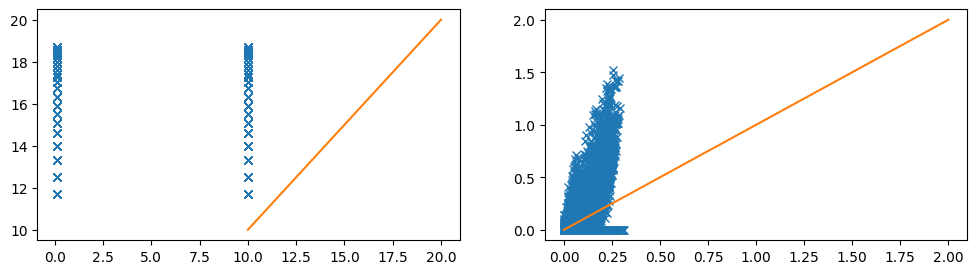

{'None': None}

In [15]:
plot(optimizer)

In [16]:
print(solvers_reconstruct)

SolversDict([(0.66, <at3d.solver.RTE object at 0x7fb1507d52a0>)])


In [17]:
final_state = state_gen.get_state()
import warnings
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 10
result = optimizer.minimize(final_state)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.675  0.119E-01    31968   203.17  0.794   [Radiance 0.660 micron]
     2  -3.485  0.119E-01    31968   203.17  0.794   [Radiance 0.660 micron]
     3  -5.684  0.119E-01    31968   203.17  0.794   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000002   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28377     M =           10

At X0      3219 variables are exactly at the bounds

At iterate    0    f=  1.60860D+05    |proj g|=  1.10721D+04
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.526  0.471E+00    31968    52.32  0.204   [Radiance 0.660 micron]
     2  -1.190  0.515E+00    31968    52.32  0.204   [Radiance 0.660 micron]
     3  -1.577  0.537E+00    31968    52.32  0.204   [Radiance 0.660 micron]
     4  -1.822  0.385E+00    32008    52.58  0.205   [Radiance 0.660 micron]
     


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28377      1     11  22279     0 22744   1.107D+04   1.609D+05
  F =   160860.35471077249     

ABNORMAL_TERMINATION_IN_LNSRCH                              


In [18]:
unknown_scatterer_indices = list(solvers_reconstruct.values())[0]._unknown_scatterer_indices - 1
unknown_scatterer_names = np.array(list(list(solvers_reconstruct.values())[0].medium.keys()))[unknown_scatterer_indices]
print(unknown_scatterer_names)
#print(objective_function(state_gen.get_state())[0].shape)
grads = (objective_function(state_gen.get_state())[1])

['cloud' 'cloud']
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.674  0.119E-01    31968   224.45  0.877   [Radiance 0.660 micron]
     2  -3.484  0.119E-01    31968   224.45  0.877   [Radiance 0.660 micron]
     3  -5.683  0.119E-01    31968   224.45  0.877   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000002   [Radiance 0.660 micron]


In [19]:
print(list(grads[:38500]))
print(x0.shape)

[-6.959004566772399, -8.289199699710583, -6.2567527029999415, -6.256665493327262, -6.257566901442219, -6.2579747591168555, -6.256404995315726, -6.253247632959354, -6.250636469016698, -6.252545014254353, -6.256905047777374, -6.25940884531781, -6.257696152649597, -6.2515747219558415, -6.23965815718011, -6.2248335733894855, -6.20780462958803, -6.189936182612415, -6.185829393805048, -6.189023209119806, -6.186662526773412, -6.1777388069429495, -6.1670960906258605, -6.1705633020036785, -6.192277873592432, -6.204001873123225, -6.1833593392457855, -1410.8847785594337, -463.6952662021254, -76.87170964134683, -596.4238852200735, -908.3339460463329, -835.3361740403208, -624.1941199199099, -494.21209972645323, -440.06289774273307, -385.8672951786749, -349.0838959425915, -340.22394864515206, -337.15028417795304, -330.12232109190865, -317.1761748014001, -298.09559690694255, -279.6599426708255, -284.9309103135718, -310.7090246256693, -324.9254764041965, -307.012497251287, -272.4927732820409, -255.310

In [20]:
# loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
            # sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
            # gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
            # uncertainty_kwargs={'add_noise': False})()
# print(gradient["gradient"][:,:,:,0].std())
# print(gradient["gradient"][:,:,:,0].mean())
# print(gradient["gradient"][:,:,:,0].max())
# print(gradient["gradient"][:,:,:,0].min())

# print(gradient["gradient"][:,:,:,1].std())
# print(gradient["gradient"][:,:,:,1].mean())
# print(gradient["gradient"][:,:,:,1].max())
# print(gradient["gradient"][:,:,:,1].min())

In [21]:
# plot(optimizer)
# print(solvers[.66].medium['cloud'].density)
# print(initial_1d_density.shape)
# print(initial_gridded_density.shape)
# print(ray_mask_pixel.shape)
print(carved_volume.mask.data[carved_volume.mask.data == 0].shape)
print(list(x0[26:]))
print(initial_gridded_reff)
print(state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff))

(3618,)
[-2.2708229783478235, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2818873682980365, -1.2

In [22]:
# plot(optimizer)
print(solvers_reconstruct[.66].medium['cloud'].density.shape)

(32, 37, 27)


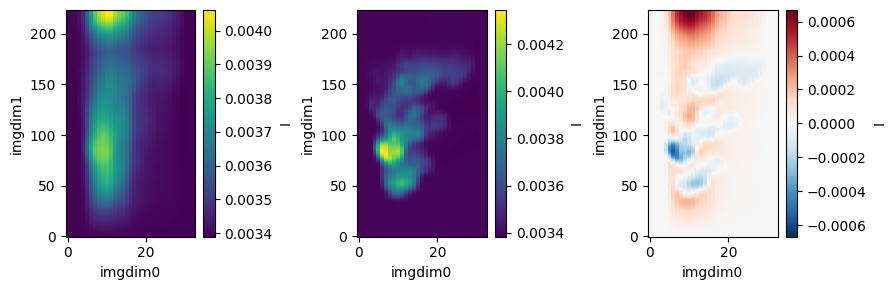

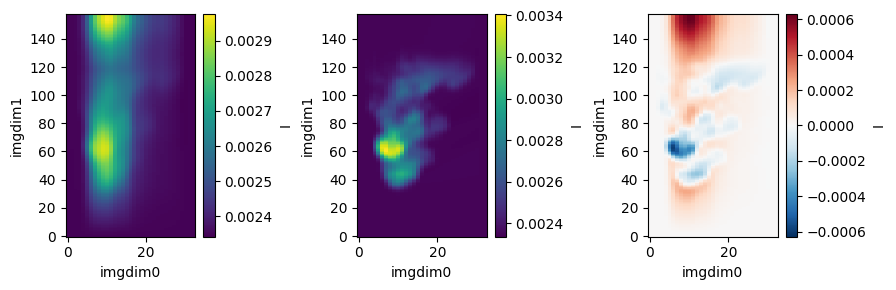

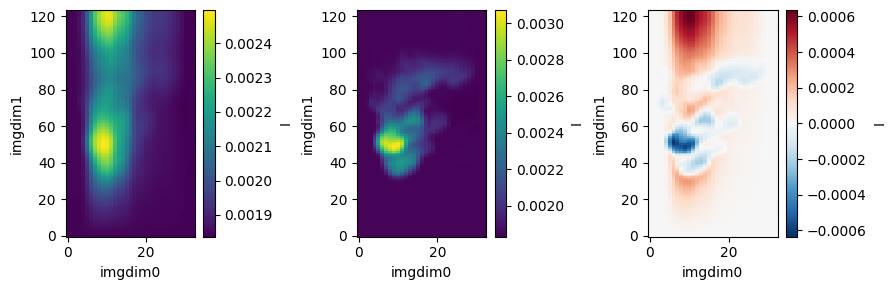

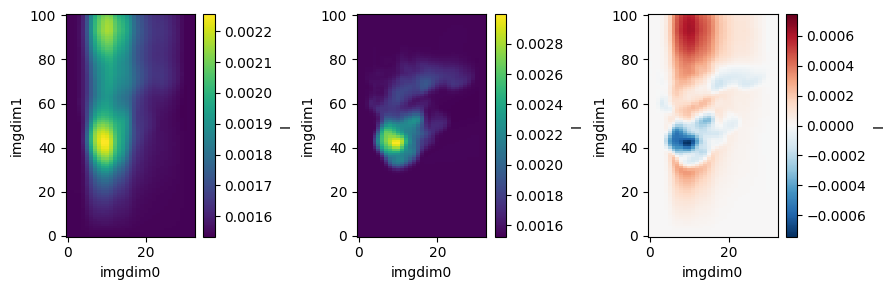

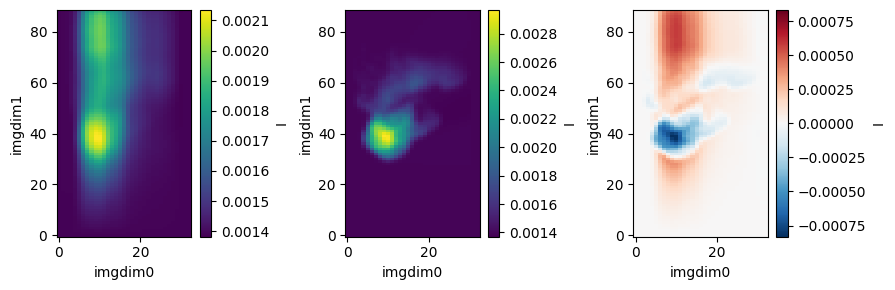

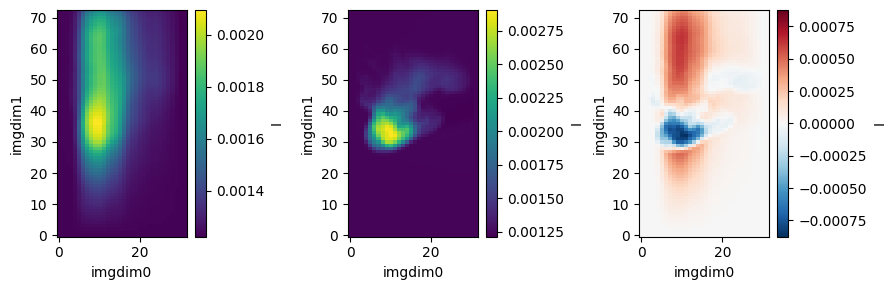

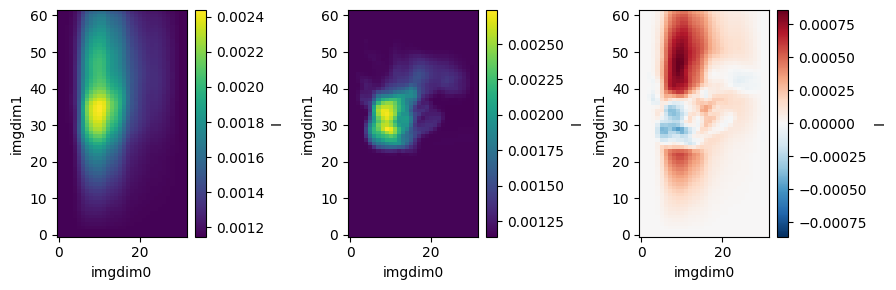

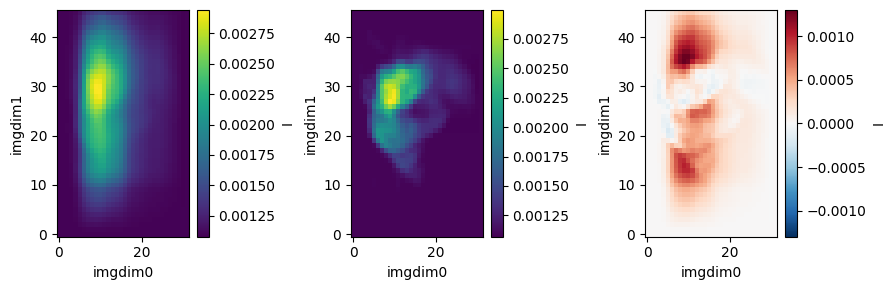

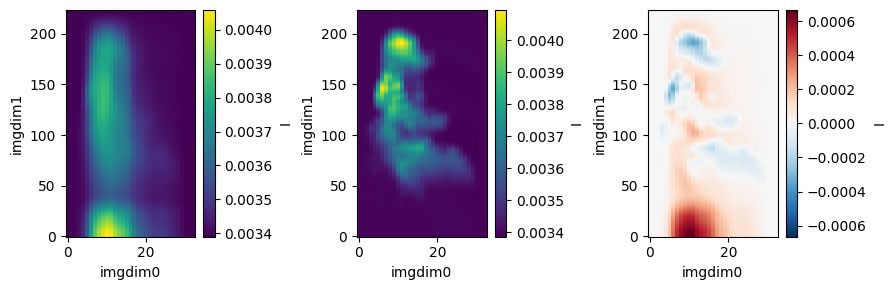

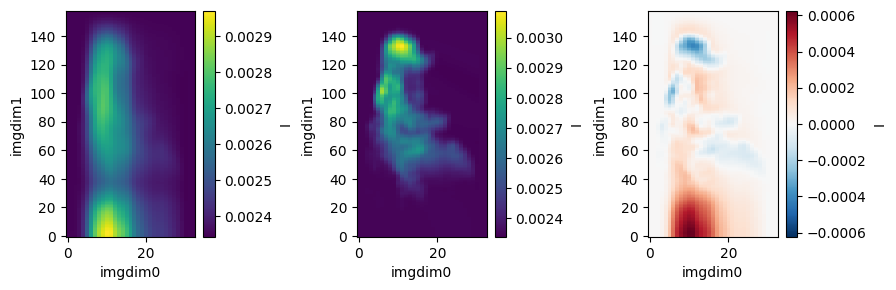

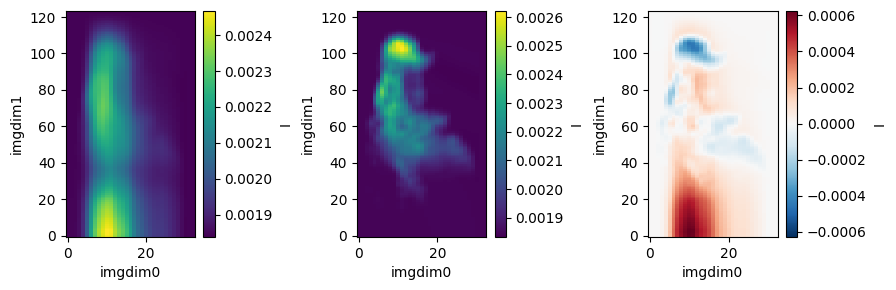

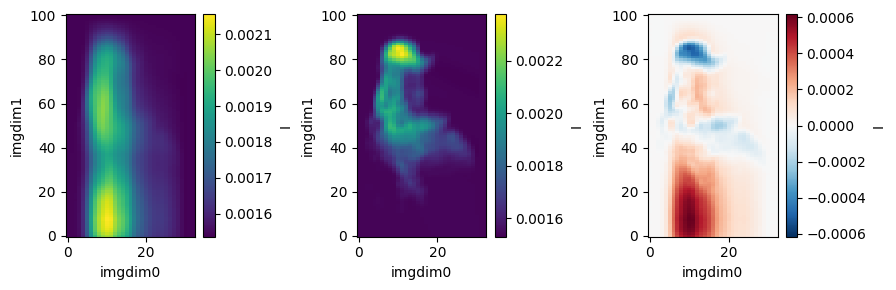

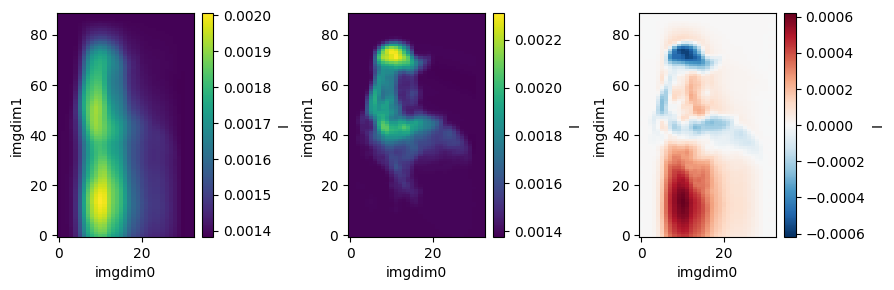

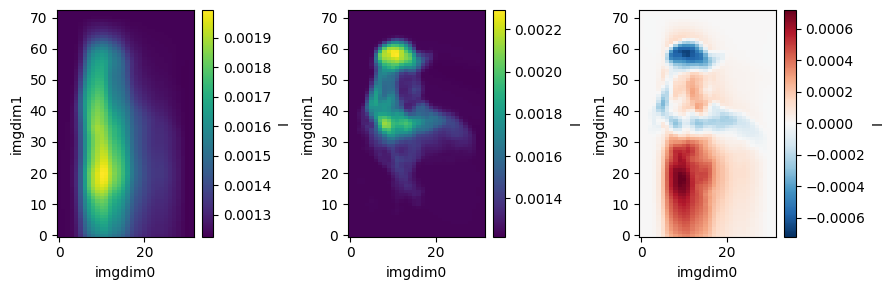

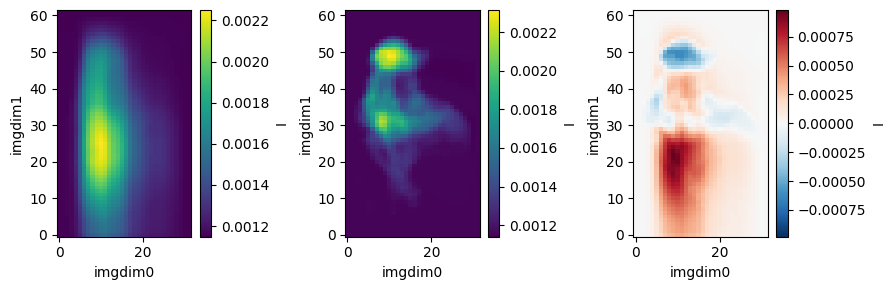

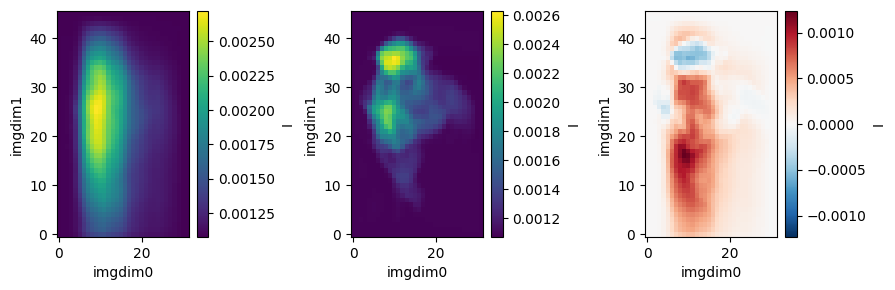

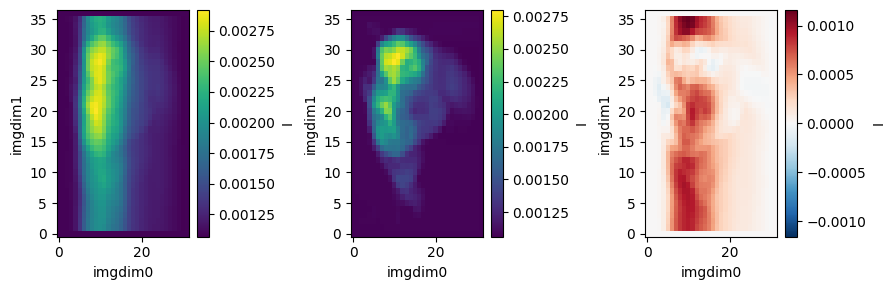

In [23]:
for instrument in forward_sensors:
    for im1,im2 in zip(forward_sensors.get_images(instrument),
                       sensors.get_images(instrument)):
        fig,ax = py.subplots(1,3, figsize=(9, 3))
        im1.I.T.plot(ax=ax[0])
        im2.I.T.plot(ax=ax[1])
        (im1.I-im2.I).T.plot(ax=ax[2])
        fig.tight_layout()